## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [7]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [8]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = [line.lower() for line in text]
text = ''.join(text)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [6]:
if not os.path.exists('onegin.txt'):
    !wget --no-check-certificate https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
        
text = [x.replace('\t\t', '') for x in text]

In [9]:
len(text)

100225

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [10]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = [line.lower() for line in text]
text = ''.join(text)

In [11]:
text[0]

' '

Put all the characters, that you've seen in the text, into variable `tokens`.

In [12]:
tokens = sorted(set(text))
print(tokens)

['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [13]:
import re
parts = re.split('\n\n\s*[a-z]*\n\n', text)

In [14]:
parts[0]

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as the riper should by time decease,\n  his tender heir might bear his memory:\n  but thou, contracted to thine own bright eyes,\n  feed'st thy light's flame with self-substantial fuel,\n  making a famine where abundance lies,\n  thy self thy foe, to thy sweet self too cruel:\n  thou that art now the world's fresh ornament,\n  and only herald to the gaudy spring,\n  within thine own bud buriest thy content,\n  and tender churl mak'st waste in niggarding:\n    pity the world, or else this glutton be,\n    to eat the world's due, by the grave and thee."

In [15]:
print(len(parts))

154


max length = 708


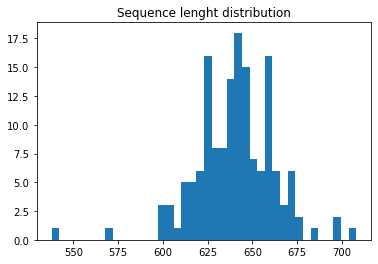

In [16]:
MAX_LENGTH = max(map(len, parts))
print("max length =", MAX_LENGTH)

plt.title("Sequence lenght distribution")
plt.hist(list(map(len, parts)), bins=40);

In [17]:
tmp = []
for i in range(0, len(parts)):
    if len(parts[i]) > 590:
        tmp.append(parts[i])

parts = tmp  

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [18]:
# dict <index>:<char>
# Your great code here
token_to_id = {char: index for index, char in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
id_to_token = {index: char for index, char in enumerate(tokens)}
num_tokens = len(tokens)

In [19]:
token_to_id[' ']

1

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [20]:
def to_matrix(parts, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    
    max_len = max_len or max(map(len, parts))
    parts_ix = np.zeros([len(parts), max_len], dtype) + pad
    
    for i in range(len(parts)):
        line_ix = [token_to_id[c] for c in parts[i]]  # строка - часть
        parts_ix[i, :len(line_ix)] = line_ix  # вставка в матрицу
        
    if not batch_first:  # convert [batch, time] into [time, batch]
        parts_ix = np.transpose(names_ix)
    
    return parts_ix

In [21]:
batch = to_matrix(parts[:5])
print(batch, batch.shape)

[[ 1  1 17 ...  1  1  1]
 [ 1  1 34 ... 23 15  8]
 [ 1  1 23 ...  1  1  1]
 [ 1  1 32 ...  1  1  1]
 [ 1  1 31 ...  1  1  1]] (5, 660)


In [22]:
batch.max(), batch.min()  # because 38 tokens in total

(37, 0)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [3]:
import numpy as np
import torch
import torch, torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [23]:
# Your code here
class CharRNNСell(nn.Module):
    """Implementation of vanila RNN cell"""
    def __init__(self, num_tokens=len(tokens), embedding_size=128, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        logits = self.rnn_to_logits(h_next)
        
        return F.log_softmax(logits, -1), h_next
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [48]:
from IPython.display import clear_output
from random import sample
from tqdm.auto import tqdm

In [25]:
char_rnn = CharRNNСell()

In [26]:
def rnn_loop(char_rnn, batch_x):
    """
    Computes log P(next_character) for all time-steps in batch_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_lenght = batch_x.shape
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []
    
    for x in batch_x.transpose(0, 1):  # transpose to get first char of each batch
        logp_next, hid_state = char_rnn(x, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [27]:
char_rnn = CharRNNСell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

In [186]:
batch = to_matrix(sample(parts, 32))
batch = torch.tensor(batch, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch)

predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch[:, 1:]

In [188]:
predictions_logp.shape

torch.Size([32, 671, 38])

In [189]:
actual_next_tokens.shape

torch.Size([32, 671])

In [190]:
batch.shape

torch.Size([32, 672])

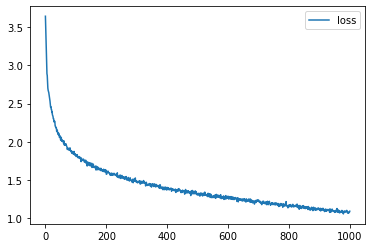

In [166]:
# Your plot code here
i_range = tqdm(range(1000))
for i in i_range:
    opt.zero_grad()
    batch = to_matrix(sample(parts, 32))
    batch = torch.tensor(batch, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch[:, 1:]
    
    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                     actual_next_tokens.contiguous().view(-1))
    loss.backward()
    opt.step()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        i_range.display()
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

In [167]:
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [168]:
np.mean(history[-10:])

1.0790616

In [28]:
MAX_LENGTH = 500

In [29]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase.lower()]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #print(x_sequence[:, -1].shape, hid_state.shape)
        _, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):

        logp_next, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence

        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [171]:
for _ in range(2):
    print(generate_sample(char_rnn, ' today', temperature=0.7))
    print('\n\n')

 today i short heavy such self-lend temptat that wake the fingers in my plame than farrents my strength and hope him, but flowers by thy new:
  for that to the ear thy sun,
  being believe all ofter i commonterss false,
  which i day should by i am,
  and for the praise adver's bloody the darking that powers and say the sen a brand in works be framed and mine eyes,
  that to the sweetis and such slop's deeds,
  to with my nature bain,
  reserve the looked for my name thou dost the dear,
  which 



 today is thee should hate,
  when in their burture that they should with power in myself do i forgets and or your spity char,
  and mine eye, my resting my poiring;
  and in leads shames as age my well,
    will worms after to belosing seen
  the guest,
  the mappity precious brow.
  but the music love, wherein 'tis their good and soul doth intokelling such serving time of your grace the ridech,
  and whire thou dost for my sake the painted wido's spring;
  will my self bright to me, or all

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [25]:
from torch.autograd import Variable

In [26]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=64, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.num_units=rnn_num_units
        
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, state):
        #assert isinstance(x.data, torch.LongTensor)
        out, state = self.rnn(self.emb(x), state)
        next_logits = self.hid_to_logits(out)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, state
    
    def initial_state(self, batch_size):
        return (torch.zeros(batch_size, self.num_units, requires_grad=True)[None, :, :].to(device),
                torch.zeros(batch_size, self.num_units, requires_grad=True)[None, :, :].to(device)
               )

In [27]:
model = CharRNNLoop().to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss().to(device)
history = []

In [37]:
batch = to_matrix(sample(parts, 32))
batch

array([[ 1,  1, 19, ...,  1,  1,  1],
       [ 1,  1, 14, ...,  1,  1,  1],
       [ 1,  1, 20, ...,  1,  1,  1],
       ...,
       [ 1,  1, 30, ...,  1,  1,  1],
       [ 1,  1, 31, ...,  1,  1,  1],
       [ 1,  1, 31, ...,  1,  1,  1]])

In [38]:
decoded = np.array([np.array([id_to_token[idx] for idx in line]) for line in batch])
decoded

array([[' ', ' ', 'h', ..., ' ', ' ', ' '],
       [' ', ' ', 'c', ..., ' ', ' ', ' '],
       [' ', ' ', 'i', ..., ' ', ' ', ' '],
       ...,
       [' ', ' ', 's', ..., ' ', ' ', ' '],
       [' ', ' ', 't', ..., ' ', ' ', ' '],
       [' ', ' ', 't', ..., ' ', ' ', ' ']], dtype='<U1')

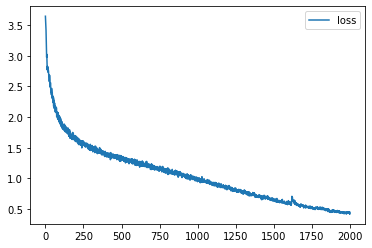

In [48]:
# Your plot code here
i_range = tqdm(range(1000))
model.train()
for i in i_range:

    opt.zero_grad()
    batch = to_matrix(sample(parts, 32))
    batch = torch.tensor(batch, dtype=torch.int64).to(device)
    
    state = model.initial_state(32)
    
    logp_seq, state = model(batch, state)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1].to(device)
    actual_next_tokens = batch[:, 1:].to(device)
    
    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                     actual_next_tokens.contiguous().view(-1))
    loss.backward()
    opt.step()
    
    history.append(loss.item())
    if (i+1)%100==0:
        clear_output(True)
        i_range.display()
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

In [54]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    char_rnn.eval()
    
    x_sequence = [token_to_id[token] for token in seed_phrase.lower()]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    zero_state = char_rnn.initial_state(batch_size=1)
    
    _, state = char_rnn(x_sequence, zero_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        
        logp_next, state = char_rnn(x_sequence[:, None, -1], state)
        # Be really careful here with the model output
        p_next = F.softmax(logp_next / temperature, dim=-1).data.to('cpu').numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.to('cpu').numpy()[0]])

In [30]:
load_checkpoint('./Lab2_LSTM/trained_model_2k.pth', model, opt)

model loaded from ./Lab2_LSTM/trained_model_2k.pth


In [33]:
for _ in range(1):
    print(generate_sample(model, ' Today is a good day ', temperature=1, max_length=500))

 today is a good day some;
  so; more the demeamsed grace ad allomect
  from smipt say you hado'd to their ehen,
  to that hear first youl own write doth hein.                                                                                                                                                                                                                                                                                                                                                     


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [34]:
# Text generation with different temperature values here
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'Temprature {temp}')
    print(generate_sample(model, ' ', temperature=temp, max_length=500))

Temprature 0.1
 when i should a madly mesire lengh so cross,
  in against thou wilt be rich dost have praise,
  he absence seem love to the grows.                                                                                                                                                                                                                                                                                                                                                                                 
Temprature 0.2
 those praise all his doth do not thy show,
    they look in old, thou be doth that youth,
    that i say me to be not but single to chess:
  every sake to thee, and thee rich sins of you,
  the owness summ were both makes this will him grow;
    that i have seen the world wist all they with me:
    then in me such men with should that i do change.'  see!
    when thoughts of seeming to show me which in my golow,
  the canst thou then, and come and what is so brong

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [72]:
save_checkpoint('./Lab2_LSTM/trained_model_2k.pth', model, opt)

model saved to ./Lab2_LSTM/trained_model_2k.pth


### Deal with Onegin

In [25]:
if not os.path.exists('onegin.txt'):
    !wget --no-check-certificate https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
        
text = [x.replace('\t\t', '') for x in text]

In [26]:
len(text)

7088

In [27]:
text = [line.lower() for line in text]
text = ''.join(text)

In [28]:
import re
ru_parts = re.split('\n[i-m]*\n\n\s*.*\s*\n\n', f'{text}')

In [29]:
ru_parts[0] = ru_parts[0][4:]

In [30]:
ru_parts[0]

'«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать не мог.\nего пример другим наука;\nно, боже мой, какая скука\nс больным сидеть и день и ночь,\nне отходя ни шагу прочь!\nкакое низкое коварство\nполуживого забавлять,\nему подушки поправлять,\nпечально подносить лекарство,\nвздыхать и думать про себя:\nкогда же черт возьмет тебя!»'

In [31]:
for i in range(len(ru_parts)):
    ru_parts[i] = ' '+ru_parts[i]

max length = 2082


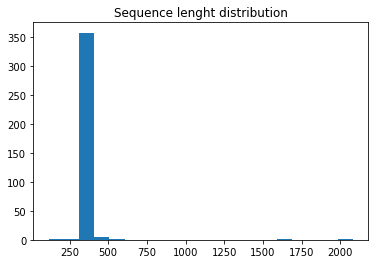

In [32]:
MAX_LENGTH = max(map(len, ru_parts))
print("max length =", MAX_LENGTH)

plt.title("Sequence lenght distribution")
plt.hist(list(map(len, ru_parts)), bins=20);

Есть много предложений длина которыз превышает основные

In [33]:
tmp = []
for i in range(0, len(ru_parts)):
    if 330 < len(ru_parts[i]) < 420:
        tmp.append(ru_parts[i])

ru_parts = tmp  

max length = 419


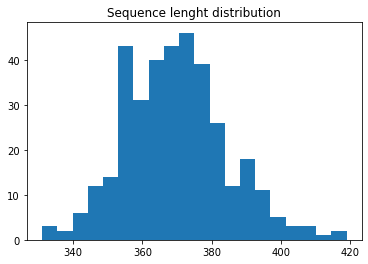

In [34]:
MAX_LENGTH = max(map(len, ru_parts))
print("max length =", MAX_LENGTH)

plt.title("Sequence lenght distribution")
plt.hist(list(map(len, ru_parts)), bins=20);

In [35]:
len(ru_parts)

360

In [36]:
tokens = set()

for name in ru_parts:
    tokens.update(set(name))

tokens = list(tokens)

num_tokens = len(tokens)

In [37]:
num_tokens

80

In [38]:
token_to_id = {char: index for index, char in enumerate(tokens)}
id_to_token = {index: char for index, char in enumerate(tokens)}
num_tokens = len(tokens)

In [39]:
def to_matrix(parts, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    
    max_len = max_len or max(map(len, parts))
    parts_ix = np.zeros([len(parts), max_len], dtype) + pad
    
    for i in range(len(parts)):
        line_ix = [token_to_id[c] for c in parts[i]]  # строка - часть
        parts_ix[i, :len(line_ix)] = line_ix  # вставка в матрицу
        
    if not batch_first:  # convert [batch, time] into [time, batch]
        parts_ix = np.transpose(names_ix)
    
    return parts_ix

In [40]:
batch = to_matrix(ru_parts[:5])
print(batch, batch.shape)

[[17 16  4 ... 17 17 17]
 [17  1 58 ... 17 17 17]
 [17 39 37 ... 17 17 17]
 [17 46 44 ... 17 17 17]
 [17  4 18 ...  4  4 41]] (5, 376)


In [42]:
batch.max(), batch.min()  # because 80 tokens in total

(79, 0)

In [45]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=64, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.num_units=rnn_num_units
        
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, num_layers=2, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, 128)
        self.lin = nn.Linear(128, num_tokens)
        
    def forward(self, x, state):
        #assert isinstance(x.data, torch.LongTensor)
        out, state = self.rnn(self.emb(x), state)
        pre_logits = self.hid_to_logits(out)
        pre_logits = nn.ReLU()(pre_logits)
        next_logits = self.lin(pre_logits)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, state
    
    def initial_state(self, batch_size):
        return (torch.zeros(2, batch_size, self.num_units, requires_grad=True).to(device),
                torch.zeros(2, batch_size, self.num_units, requires_grad=True).to(device)
               )

In [46]:
model = CharRNNLoop().to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss().to(device)
history = []

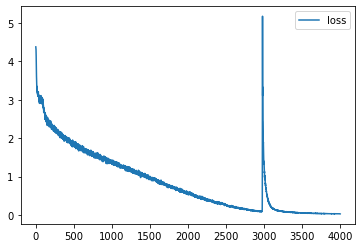

In [83]:
# Your plot code here
i_range = tqdm(range(1000))
model.train()
for i in i_range:

    opt.zero_grad()
    batch = to_matrix(sample(ru_parts, 32))
    batch = torch.tensor(batch, dtype=torch.int64).to(device)
    
    state = model.initial_state(32)
    
    logp_seq, state = model(batch, state)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1].to(device)
    actual_next_tokens = batch[:, 1:].to(device)
    
    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                     actual_next_tokens.contiguous().view(-1))
    loss.backward()
    opt.step()
    
    history.append(loss.item())
    if (i+1)%100==0:
        clear_output(True)
        i_range.display()
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

In [84]:
save_checkpoint('./Lab2_LSTM/trained_ru_model_with_non_linear.pth', model, opt)

model saved to ./Lab2_LSTM/trained_ru_model_with_non_linear.pth


In [86]:
np.mean(history[-10:])

0.032282343879342076

In [87]:
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [112]:
for _ in range(1):
    print(generate_sample(model, ' шагане', temperature=1.5, max_length=500))

 шагане ветрена встреча;
он сынчет утренней прихоле;
но то, бурный едва его,
утих, завет, на злочтовенно,
нашх усощащесей рифмащий
угодит на суд; т был зовут:
счавил эта осушлима;
толсты цветы отрекных махмом,
хранил… к как велиных общед!                                                                                                                                                                                                                                                                      


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)